<h1>자전거 대여 시스템 EDA 및 모델링</h1>

<h3>환경설정</h3>

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import platform 
import os # 캐시 삭제를 위해 os 모듈 추가



from matplotlib import  rc
print(plt.rcParams['font.family'])

import platform



# ---------------------------------------------------------
# 1. 한글 폰트 설정 (수정됨: 폰트 우선순위 목록 방식으로 변경)
# ---------------------------------------------------------
# 운영체제에 따라 폰트 설정
if platform.system() == 'Darwin':  # MacOS
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # Windows
    rc('font', family='Malgun Gothic')
else:  # Linux (e.g., Colab or other server environment)
    # **가장 안정적인 리눅스 환경 폰트 설정**
    # 특정 폰트 파일 경로 검색 대신, 여러 가능한 한글 폰트 목록을 설정하여
    # 시스템이 지원하는 폰트를 자동으로 찾도록 합니다.
    # Matplotlib은 목록에서 사용 가능한 첫 번째 폰트를 사용합니다.
    korean_font_families = ['NanumGothic', 'Malgun Gothic', 'AppleGothic', 'NanumBarunGothic', 'sans-serif']
    
    # 폰트 목록을 설정합니다.
    rc('font', family=korean_font_families)
    print(f"정보: 리눅스 환경에서 폰트 우선순위 목록을 설정했습니다: {korean_font_families}")


# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False




['AppleGothic']


<h3>Description</h3>

 - datetime	자전거 대여 기록의 날짜 및 시간. 예시: 2011-01-01 00:00:00

- season	int	계절 (1: 봄, 2: 여름, 3: 가을, 4: 겨울)

- holiday	int	공휴일 여부 (0: 평일, 1: 공휴일)

- workingday	int	근무일 여부 (0: 주말/공휴일, 1: 근무일)

- weather	int	날씨 상황 (1: 맑음, 2: 구름낌/안개, 3: 약간의 비/눈, 4: 폭우/폭설)

- temp	float	실측 온도 (섭씨)

- atemp	float	체감 온도 (섭씨)

- humidity	int	습도 (%)

- windspeed	float	풍속 (m/s)

- casual	int	등록되지 않은 사용자의 대여 수

- registered	int	등록된 사용자의 대여 수

- count	int	총 대여 수 (종속 변수)

<h3>데이터 구조파악</h3>

In [43]:

train = pd.read_csv("data/train.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [23]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [24]:
#수치형 데이터 통계요약
 #-스케일 파악: 각 변수의 값 범위(최소-최대)를 파악하여 전처리(스케일링)가 필요한지 판단합니다.
 #이상치/편향 확인: 평균($\text{mean}$)과 중앙값($\text{50\%}$)의 차이를 통해 데이터의 분포가 한쪽으로 쏠려 있는지(편향) 또는 극단적인 이상치가 있는지 초기 징후를 파악할 수 있습니다.
 
 # 이부분은 나중에 데이터분석을다시 해보자
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


<h3>결측치 확인</h3>

In [40]:
#결측치가 별견되지 않음
train.info()
train.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  hour        10886 non-null  int32         
 13  dayofweek   10886 non-null  int32         
 14  month       10886 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(3), int64(8)
memory usage: 1.1

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
hour          0
dayofweek     0
month         0
dtype: int64

<h3>데이터 시각화</h3>

<p>우선 1차적으로 시간기반 대여량이 가장중요한 요소라고 판단됨으로 처음에 시간을중점으로 분석 시작</p>

<h4>1. 시간대별 평균 자전거 대여량<h4>

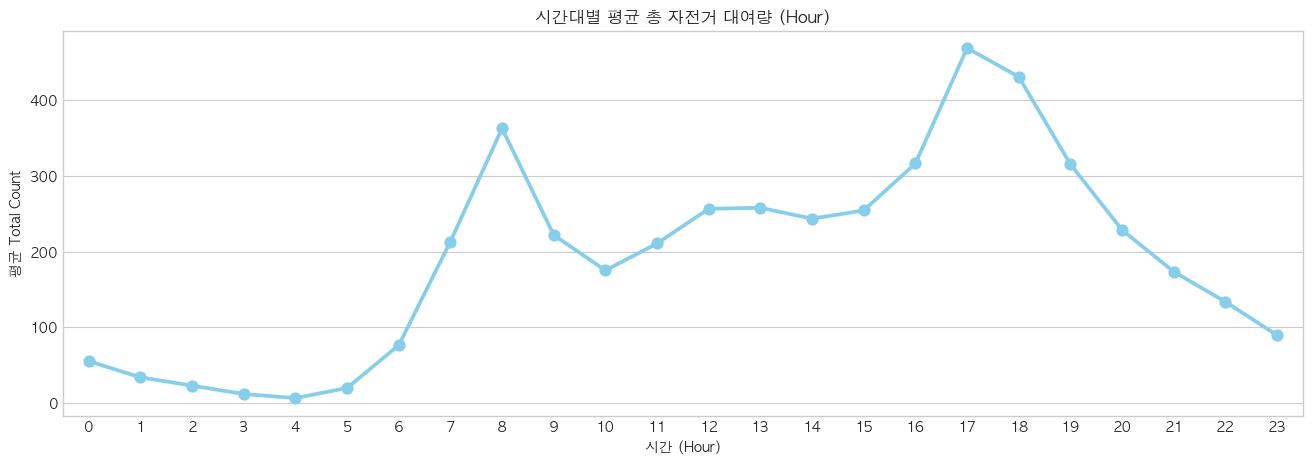

In [46]:
#시간 데이터 추출
train['datetime'] = pd.to_datetime(train['datetime'])
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek
train['month'] = train['datetime'].dt.month


# 4-1. 시간대(Hour)별 패턴 분석 (총 대여량)
plt.figure(figsize=(16, 5))
sns.pointplot(x='hour', y='count', data=train, color='skyblue', ci=None)
plt.title('시간대별 평균 총 자전거 대여량 (Hour)')
plt.ylabel('평균 Total Count')
plt.xlabel('시간 (Hour)')
plt.show()

<h5>분석</h5>
<p> - 데이터가 6~10시 구간, 16시~19시 구간에 재여량이 많습니다.   </p>
<p> 출퇴근, 혹은 등하교 시간대라 대여량이 급증하는걸로 예상됨<p>
<p> 이구간 데이터수치대로 모델링하면 편하겠지만, 좀더 머신러닝때 정확하게 하기위해 다른데이터를 추가해서 세분화 시킬필요가 있습니다.<p>
<p> 세분화할시 여러가지가 있겠지만 출퇴근이나 등하교에 관련이 가장 클거같으므로 주말과 평일을 데이터를 나누어서 분석해볼필요가 있습니다.<p>
<p> 그전에 registered 컬럼별로 대여량차이가 있는지 확인하고 나눠서 예측할필요가 있습니다.  <p>

<h5>1 - 1. 시간대별 평균 자전거 대여량 회원별로(Registered)<h5>

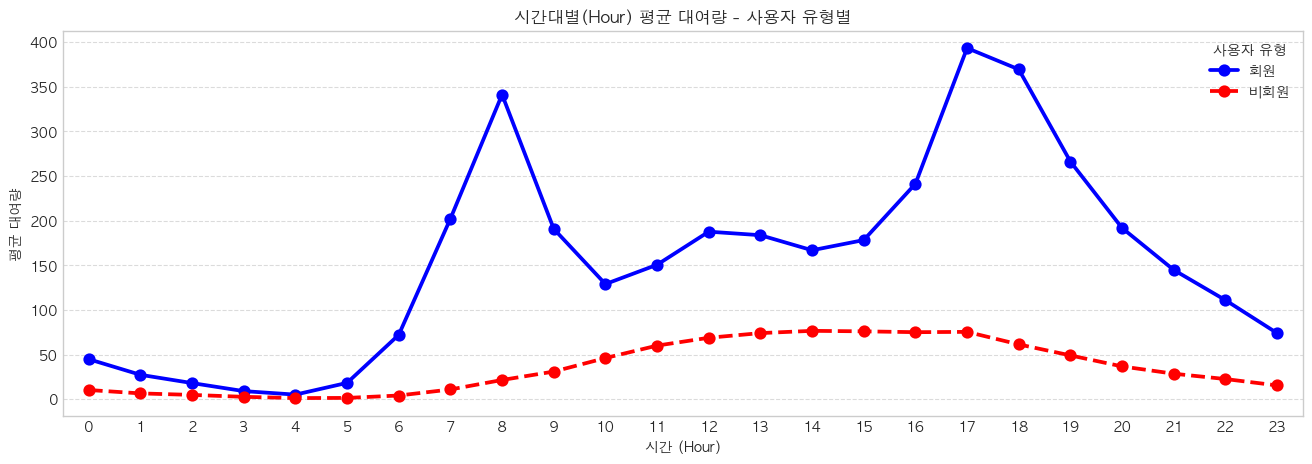

In [53]:
plt.figure(figsize=(16, 5))

# 등록 사용자 (Registered) 시간대별 평균 대여량 (한글 레이블 사용)
sns.pointplot(x='hour', y='registered', data=train, 
              linestyles='-', color='blue', label='회원', ci=None)

# 비등록 사용자 (Casual) 시간대별 평균 대여량 (한글 레이블 사용)
sns.pointplot(x='hour', y='casual', data=train, 
              linestyles='--', color='red', label='비회원', ci=None)

# 그래프 제목 및 축 레이블 설정
plt.title('시간대별(Hour) 평균 대여량 - 사용자 유형별')
plt.ylabel('평균 대여량')
plt.xlabel('시간 (Hour)')

# 범례를 표시합니다.
plt.legend(title='사용자 유형', labels=['회원', '비회원'])

plt.grid(True, axis='y', linestyle='--', alpha=0.7) 
plt.xticks(range(0, 24)) 
plt.show()

<h5>분석</h5>
<p> 회원/비회원 대여량 차이가 있습니다. 요금제라던지 사용편의성이라던지 확실한 이유가 존재하리라 예측합니다.</p>
<p> 정확한 데이터를위해 앞으로 필요한경우 나눠서 데이터를예측하고 만약에 큰변동없이 낮은 대여수를 유지한다면 회원,비회원 합쳐서 모델링해도 무방할거라 예측</p>

<h4>2. 요일별 대여량<h4>

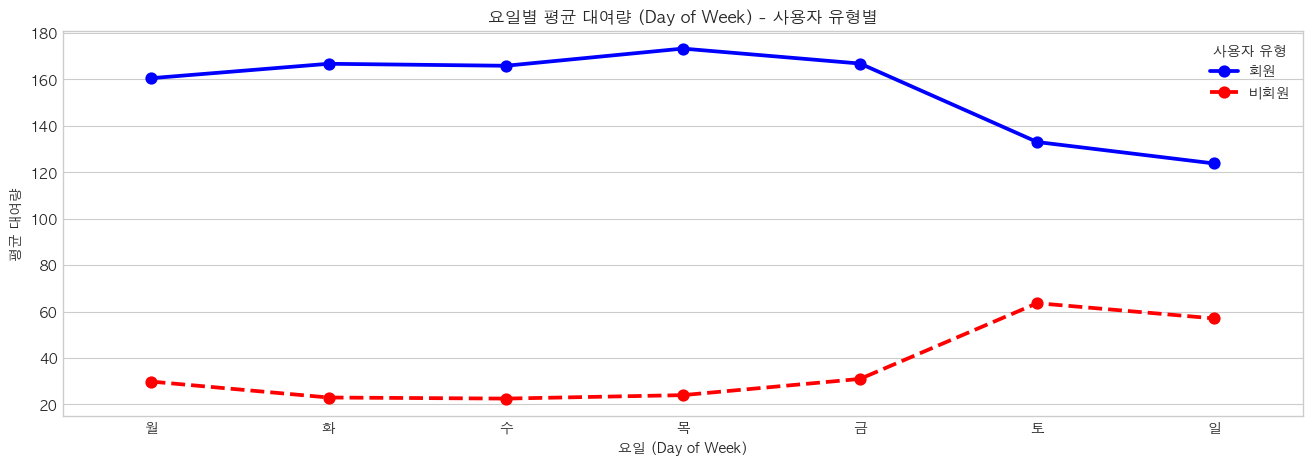

In [52]:

# 4-2. 요일(Day of Week)별 패턴 분석 (등록/비등록 사용자 분리)
plt.figure(figsize=(16, 5))
sns.pointplot(x='dayofweek', y='registered', data=train, linestyles='-', color='blue', label='회원', ci=None)
sns.pointplot(x='dayofweek', y='casual', data=train, linestyles='--', color='red', label='비회원', ci=None)

plt.title('요일별 평균 대여량 (Day of Week) - 사용자 유형별')
plt.gca().set_xticklabels(['월', '화', '수', '목', '금', '토', '일'])
plt.ylabel('평균 대여량')
plt.xlabel('요일 (Day of Week)')
plt.legend(title='사용자 유형')
plt.show()

<h5>분석</h5>
<p>  </p>
<p> </p>


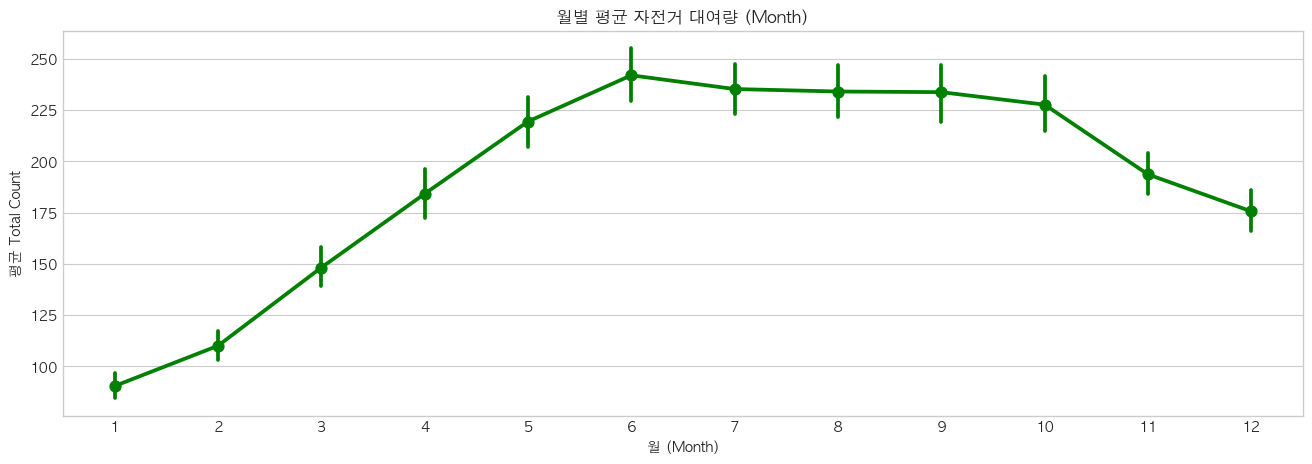

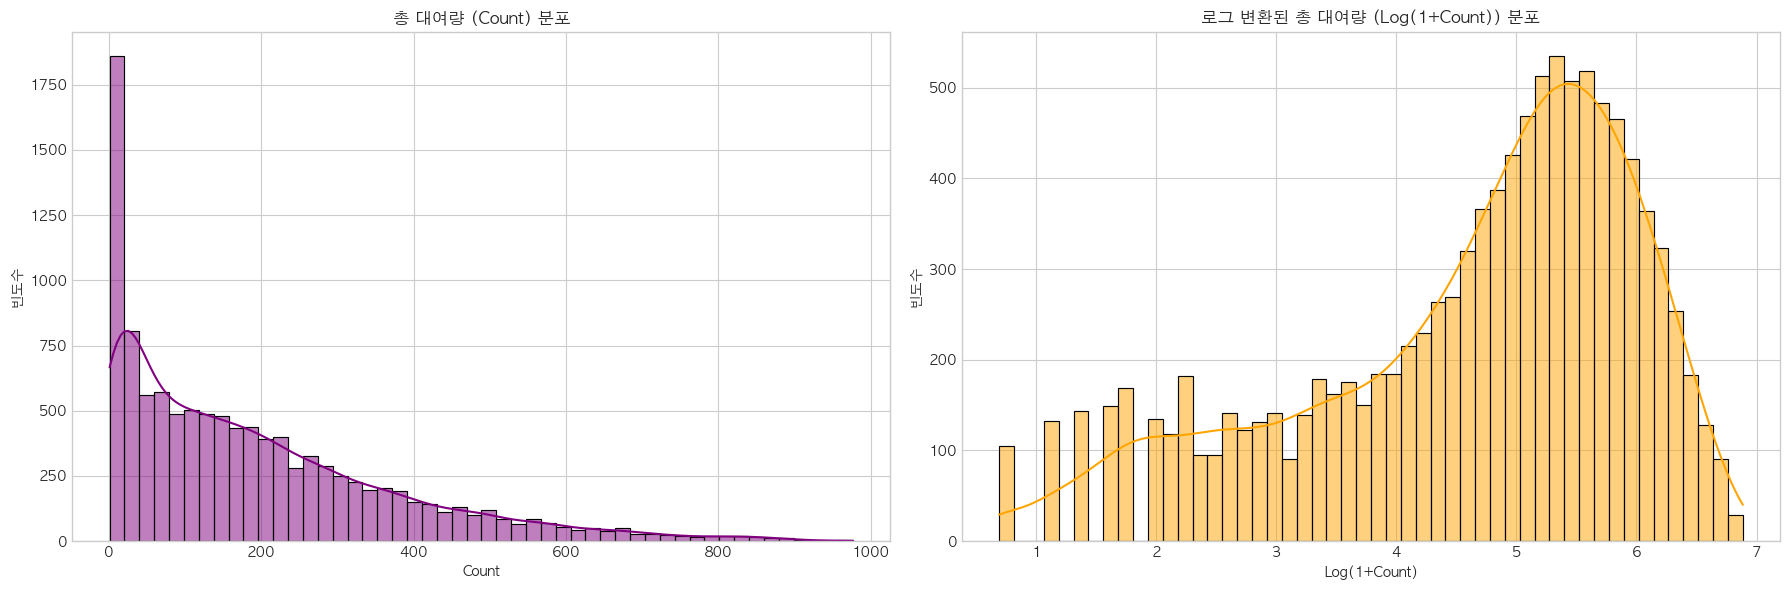

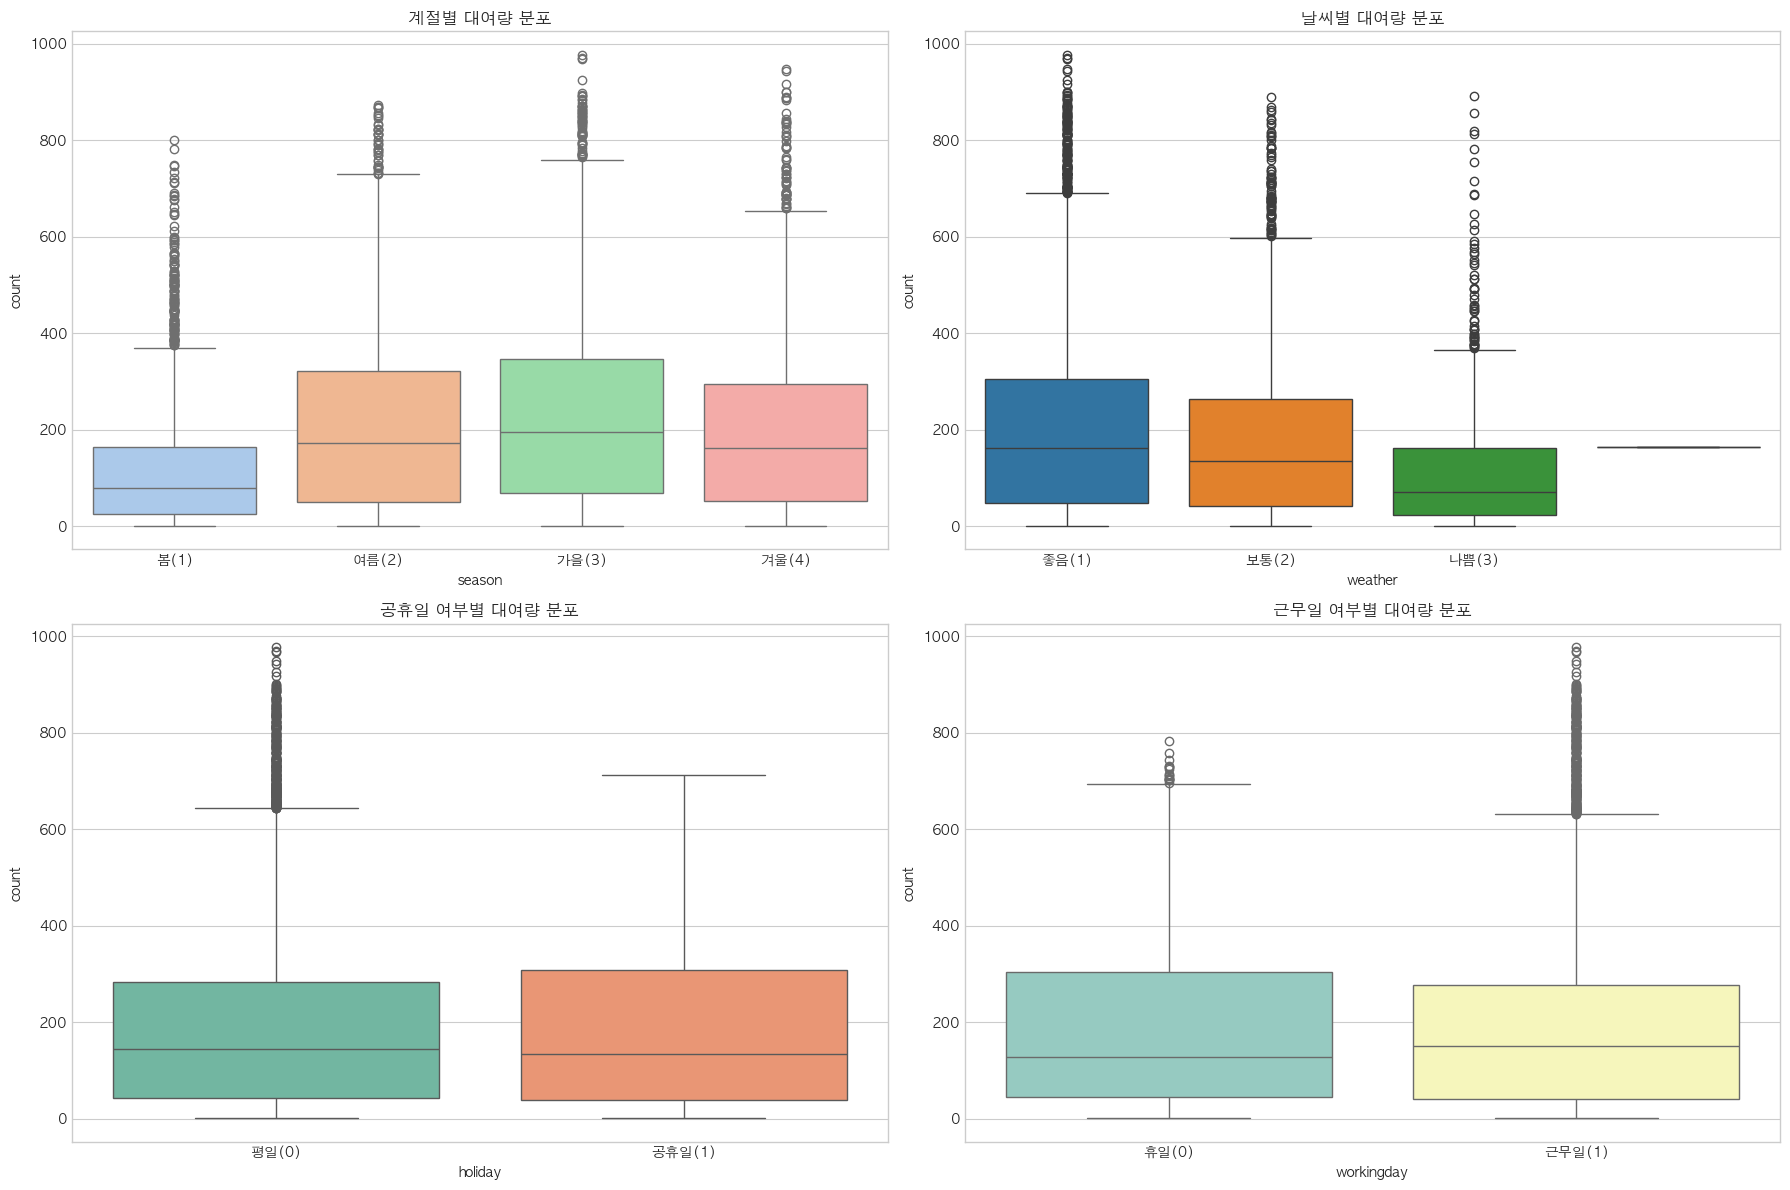

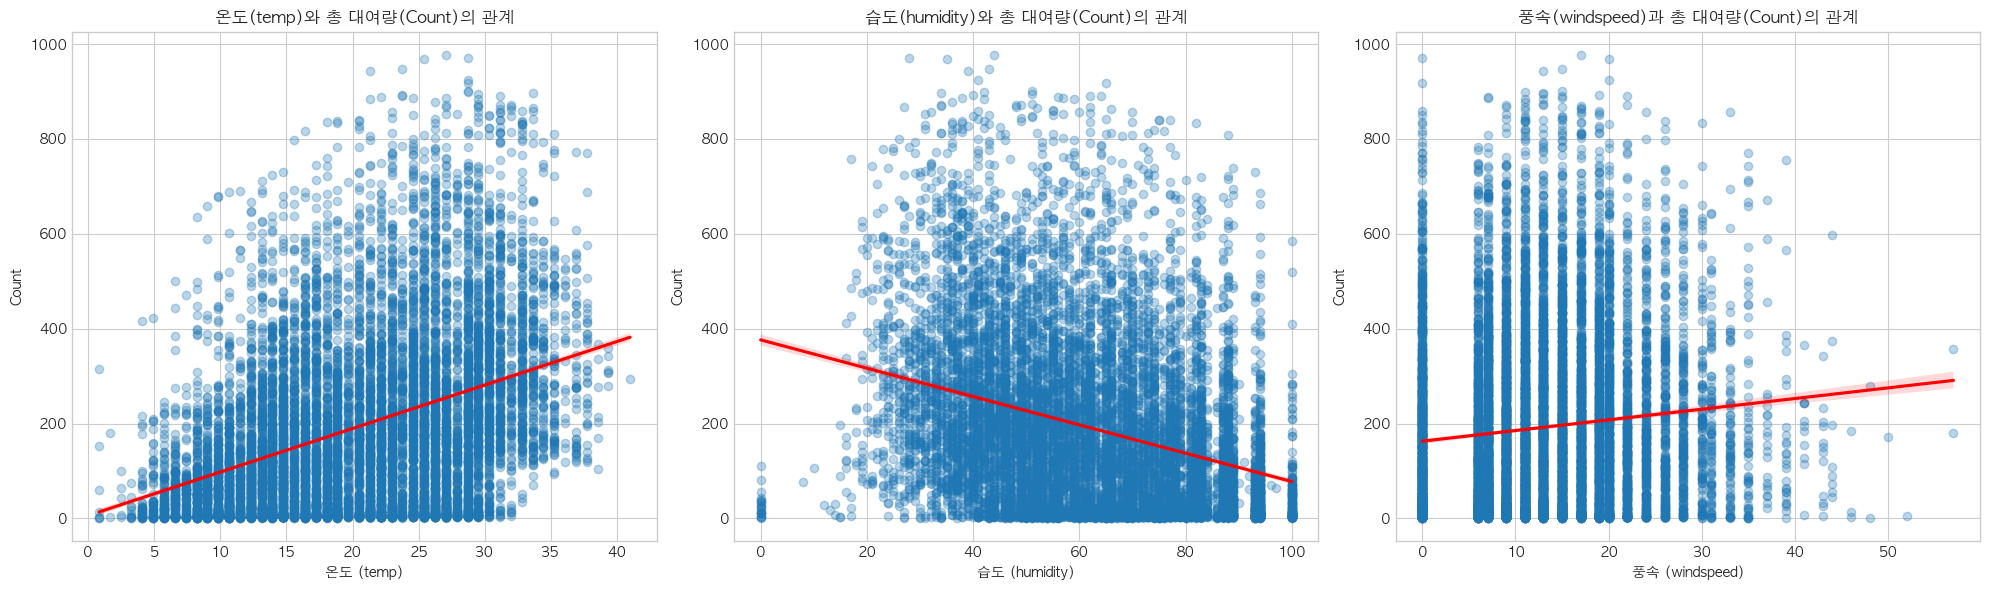

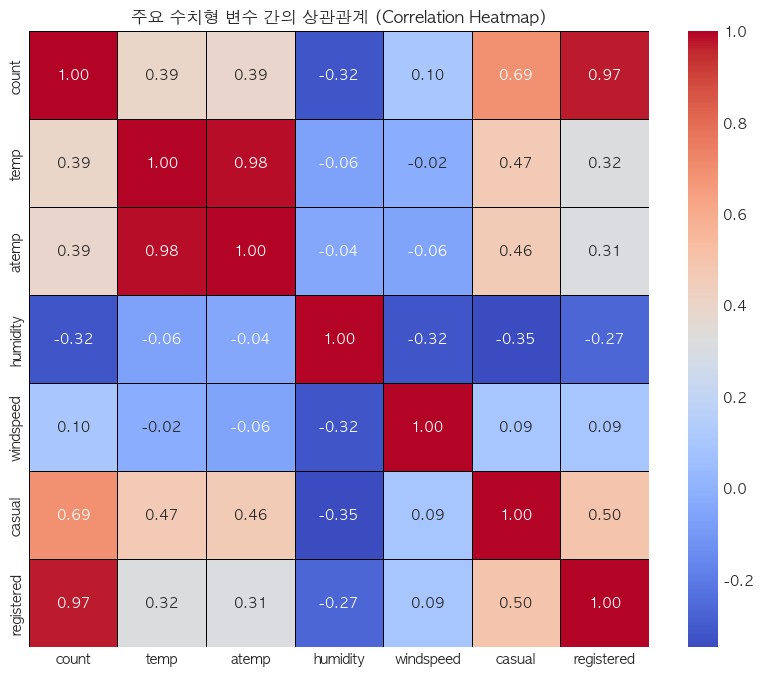

In [54]:






# 4-3. 월(Month)별 패턴 분석
plt.figure(figsize=(16, 5))
sns.pointplot(x='month', y='count', data=train, color='green')
plt.title('월별 평균 자전거 대여량 (Month)')
plt.xlabel('월 (Month)')
plt.ylabel('평균 Total Count')
plt.show()

# =========================================================
# 5. 타겟 변수 및 범주형 특성 분석
# =========================================================

# 5-1. 타겟 변수 (count)의 분포 확인 및 로그 변환 필요성 판단
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))

# 원본 'count' 분포
sns.histplot(train['count'], ax=ax1, bins=50, kde=True, color='purple')
ax1.set_title('총 대여량 (Count) 분포')
ax1.set_xlabel('Count')
ax1.set_ylabel('빈도수')

# 로그 변환된 'count' 분포 (로그 변환 시 0 값 처리: log(1+x))
sns.histplot(np.log1p(train['count']), ax=ax2, bins=50, kde=True, color='orange')
ax2.set_title('로그 변환된 총 대여량 (Log(1+Count)) 분포')
ax2.set_xlabel('Log(1+Count)')
ax2.set_ylabel('빈도수')

plt.tight_layout()
plt.show()

# 5-2. 범주형 특성별 'count' 분포 (Box Plot)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 12))

# season (계절)
sns.boxplot(x='season', y='count', data=train, ax=axes[0, 0], palette='pastel')
axes[0, 0].set_title('계절별 대여량 분포')
axes[0, 0].set_xticklabels(['봄(1)', '여름(2)', '가을(3)', '겨울(4)'])

# weather (날씨)
sns.boxplot(x='weather', y='count', data=train, ax=axes[0, 1], palette='tab10')
axes[0, 1].set_title('날씨별 대여량 분포')
axes[0, 1].set_xticklabels(['좋음(1)', '보통(2)', '나쁨(3)'])

# holiday (공휴일)
sns.boxplot(x='holiday', y='count', data=train, ax=axes[1, 0], palette='Set2')
axes[1, 0].set_title('공휴일 여부별 대여량 분포')
axes[1, 0].set_xticklabels(['평일(0)', '공휴일(1)'])

# workingday (근무일)
sns.boxplot(x='workingday', y='count', data=train, ax=axes[1, 1], palette='Set3')
axes[1, 1].set_title('근무일 여부별 대여량 분포')
axes[1, 1].set_xticklabels(['휴일(0)', '근무일(1)'])

plt.tight_layout()
plt.show()

# =========================================================
# 6. 수치형 특성 분석: 온도, 습도, 풍속 vs 대여량
# =========================================================

# 6-1. 주요 수치형 특성과 Count의 관계 (산점도)
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 6))

# 온도 (temp) vs Count
sns.regplot(x='temp', y='count', data=train, ax=ax1, scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
ax1.set_title('온도(temp)와 총 대여량(Count)의 관계')
ax1.set_xlabel('온도 (temp)')
ax1.set_ylabel('Count')

# 습도 (humidity) vs Count
sns.regplot(x='humidity', y='count', data=train, ax=ax2, scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
ax2.set_title('습도(humidity)와 총 대여량(Count)의 관계')
ax2.set_xlabel('습도 (humidity)')
ax2.set_ylabel('Count')

# 풍속 (windspeed) vs Count
sns.regplot(x='windspeed', y='count', data=train, ax=ax3, scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
ax3.set_title('풍속(windspeed)과 총 대여량(Count)의 관계')
ax3.set_xlabel('풍속 (windspeed)')
ax3.set_ylabel('Count')

plt.tight_layout()
plt.show()

# =========================================================
# 7. 상관관계 분석 (Correlation Matrix Heatmap)
# =========================================================

# 분석에 사용할 수치형 컬럼 목록
corr_cols = ['count', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered']

# 상관관계 행렬 계산
corr_matrix = train[corr_cols].corr()

plt.figure(figsize=(10, 8))
# 히트맵 시각화
sns.heatmap(corr_matrix,
            annot=True,        # 값 표시
            fmt='.2f',         # 소수점 둘째 자리까지 표시
            cmap='coolwarm',   # 색상 맵
            linewidths=0.5,    # 선 간격
            linecolor='black')

plt.title('주요 수치형 변수 간의 상관관계 (Correlation Heatmap)')
plt.show()
